# %% [markdown]
# # Starbucks Capstone Challenge
# 
# ### Introduction
# 
# This dataset simulates customer behavior on the Starbucks rewards mobile app, where users receive different types of offers. Your task is to analyze transaction, demographic, and offer data to determine which demographic groups respond best to which offer type. The data represents a simplified version of the Starbucks app, and it includes information about offers' validity periods. Additionally, the dataset contains transactional data, including user purchases, offer receptions, views, and completions. Users might make purchases without receiving or viewing offers.
# 
# ### Example
# 
# For instance, consider a scenario where a user receives a discount offer: "Spend $10 and get $2 off" on a Monday. This offer remains valid for 10 days from the day it's received. If the customer makes purchases totaling at least $10 during this validity period, the offer is considered completed.
# 
# However, there are some nuances to be aware of in this dataset. Customers do not actively choose the offers they receive. In other words, a user can receive an offer, never actually open or view it, and still complete the offer. For example, a user might receive the "Spend $10 and get $2 off" offer but never opens it during the 10-day validity period. Despite this, if the customer spends $15 within those ten days, there will be a record indicating offer completion in the dataset. However, it's important to note that the customer wasn't influenced by the offer since they never viewed it.
# 
# ### Cleaning
# 
# Data cleaning becomes particularly crucial and challenging in this context.
# 
# It's essential to consider that certain demographic segments may make purchases even without receiving offers. From a business standpoint, if a customer is likely to make a $10 purchase without any offer, it doesn't make sense to send them a "Spend $10 and get $2 off" offer. Instead, the goal is to understand what specific products or services a particular demographic group typically purchases without the influence of offers.
# 
# ### Final Advice
# 
# Since this is a capstone project, you have the flexibility to analyze the data in any manner you deem appropriate. For instance, you can construct a machine learning model to forecast a person's spending based on their demographic details and the type of offer they receive. Alternatively, you can create a model to predict whether an individual is likely to respond to an offer. However, it's not mandatory to develop a machine learning model at all. You have the option to formulate a set of guidelines or rules that help determine which offer to send to each customer. For instance, you might decide to send "Offer A" to 75 percent of female customers aged 35 who have responded, compared to 40 percent of the same demographic who responded to "Offer B."

# %% [markdown]
# # Data Sets
# 
# The data is distributed across three files:
# 
# **portfolio.json**
# - `id` (string) - Offer ID
# - `offer_type` (string) - Offer type, such as BOGO, discount, or informational
# - `difficulty` (int) - Minimum spending requirement to fulfill an offer
# - `reward` (int) - Reward granted upon successful offer completion
# - `duration` (int) - Offer duration in days
# - `channels` (list of strings) - Communication channels for the offer
# 
# **profile.json**
# - `age` (int) - Customer's age
# - `became_member_on` (int) - Date when the customer registered an app account
# - `gender` (str) - Customer's gender (noting that some entries are marked 'O' for other, rather than 'M' or 'F')
# - `id` (str) - Customer ID
# - `income` (float) - Customer's income
# 
# **transcript.json**
# - `event` (str) - Description of the record (e.g., transaction, offer received, offer viewed)
# - `person` (str) - Customer ID
# - `time` (int) - Time in hours since the start of the test (data commences at time t=0)
# - `value` (dict of strings) - Contains either an offer ID or a transaction amount, depending on the record
# 

# %% [markdown]
# # Business Understanding
# 
# The objective here is to find patterns and show when and where to give specific offer to a specific customer.

# %%

In [131]:
import pandas as pd
import numpy as np
import math
import json

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [132]:
# read in the json files
portfolio = pd.read_json('/kaggle/input/project3-tindt3/data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('/kaggle/input/project3-tindt3/data/profile.json', orient='records', lines=True)
transcript = pd.read_json('/kaggle/input/project3-tindt3/data/transcript.json', orient='records', lines=True)

# # 1. Data Cleaning
# ## 1.1. Portfolio
# - Rename the 'id' column to 'offer_id'.
# - Split the 'channels' into separate columns.
# - Dissect the 'offer_type' into distinct columns.
# 

In [133]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [134]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [135]:
# Re-name the id column to offer_id.
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [136]:
# Re-name the id column to offer_id.
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

# Split the 'channels' into multiple columns.
channel_dummies = portfolio['channels'].str.join('|').str.get_dummies()
portfolio = pd.concat([portfolio, channel_dummies], axis=1)
portfolio.drop(columns=['channels'], inplace=True)

# Out-put check :
portfolio.head()


,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


## 1.2. Profile
# Substitute "id" with "customer_id."
# Rectify the date format.
# Address inconsistencies in the "age" column.
# In both the gender and income columns, there are 2,175 missing values (17,000 - 14,825).

In [137]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [138]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [139]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [140]:
# Re-name "id" with "customer_id"
profile.rename(columns={'id':'customer_id'},inplace=True)

# Fix the date.
profile['became_member_on'] = profile['became_member_on'].apply(lambda x: pd.to_datetime(str(x),format='%Y%m%d'))

profile['income'].fillna((profile['income'].mean()), inplace=True)

# Identify customers with irregular ages and exclude them from consideration by introducing a new column called "valid."
ages = profile['age'].unique()
perct_old_ages = profile['age'][profile['age'] > 100].count()/profile['age'].count() * 100
print('''
Unique ages in the df: {},
% customers who has the age > 100: {} %
'''.format(ages, round(perct_old_ages,2)))
profile['valid'] = profile['age'].apply(lambda x: 1 if x <= 100 else 0)

# # Out-put check :
profile.head()




Unique ages in the df: [118  55  75  68  65  58  61  26  62  49  57  40  64  78  42  56  33  46
  59  67  53  22  96  69  20  45  54  39  41  79  66  29  44  63  36  76
  77  30  51  27  73  74  70  89  50  90  60  19  72  52  18  71  83  43
  47  32  38  34  85  48  35  82  21  24  81  25  37  23 100  28  84  80
  87  86  94  31  88  95  93  91  92  98 101  97  99],
% customers who has the age > 100: 12.82 %



,gender,age,customer_id,became_member_on,income,valid
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.000000,1
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,65404.991568,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.000000,1
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,65404.991568,0


## 1.3. Transcript
# Update the name of the "person" column to "customer_id."
# Generate dummy variables for the "event" column.
# Expand the values within the "value" column.


In [141]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [142]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [143]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [144]:
# Rename the "person" column to "customer_id".
transcript.rename(columns={'person':'customer_id'},inplace=True)

# Unlist the values in "value" column.
transcript['offer_id'] = [list(x.values())[0]  if (list(x.keys())[0] in ['offer_id', 'offer id']) else np.nan for x in transcript['value']]
transcript['amount'] = [list(x.values())[0]  if (list(x.keys())[0] in ['amount']) else np.nan for x in transcript['value']]
transcript.drop(columns=['value'],inplace=True)


# Result:
transcript.head()

,customer_id,event,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


## 1.4. Merge datasets

In [145]:
df = pd.merge(transcript, profile, on='customer_id', how="left")
df = pd.merge(df, portfolio, on='offer_id', how="left")
df.head()

,customer_id,event,time,offer_id,amount,gender,age,became_member_on,income,valid,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.000000,1,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,None,118,2017-08-04,65404.991568,0,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,M,68,2018-04-26,70000.000000,1,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,None,118,2017-09-25,65404.991568,0,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,118,2017-10-02,65404.991568,0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0


In [146]:
# Streamline  the offer_id:
offer_ids = df['offer_id'].unique()
cnt = 1
offer_list = {}
for offer in offer_ids:
    offer_list[offer] = 'X'+str(cnt)
    cnt += 1
df['offer_id'] = df['offer_id'].apply(lambda x: offer_list[x] if (x in offer_list.keys()) else x)

# Streamline  the customer_id:
customer_ids = profile['customer_id'].unique()
count = 1
customer_list = {}
for cus in customer_ids:
    customer_list[cus] = 'A'+str(count)
    count += 1
df['customer_id'] = df['customer_id'].apply(lambda x: customer_list[x] if (x in customer_list.keys()) else x)

# Add "age_group" for analysis purpose
df['age_group'] = pd.cut(df['age'], bins=[0, 12, 18, 21, 64, 200], 
                        labels=['child', 'teen', 'young adult', 'adult', 'elderly'])

df.head()

,customer_id,event,time,offer_id,amount,gender,age,became_member_on,income,valid,reward,difficulty,duration,offer_type,email,mobile,social,web,age_group
0,A4,offer received,0,X1,NaN,F,75,2017-05-09,100000.000000,1,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,elderly
1,A5,offer received,0,X2,NaN,None,118,2017-08-04,65404.991568,0,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,elderly
2,A6,offer received,0,X3,NaN,M,68,2018-04-26,70000.000000,1,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,elderly
3,A7,offer received,0,X4,NaN,None,118,2017-09-25,65404.991568,0,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,elderly
4,A8,offer received,0,X5,NaN,None,118,2017-10-02,65404.991568,0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,elderly


# 2. Analyze
## 2.1.  Univariate Exploration:

# 
# 1. What constitutes the average income of a Starbucks customer?
# 2. How does the average age of a Starbucks customer look?
# 3. Which promotion among the following is the most prevalent?
# 4. What are the primary values in each column of each dataframe?
# 5. In the context of transcripts, who qualifies as the most devoted customer?

Let's start with the first question:

**1. What comprises the mean income of Starbucks customers?**

In [147]:
print('The average income for Starbucks customers: ', round(profile['income'].mean(),2))

The average income for Starbucks customers:  65404.99


**2.What is the mean age of the typical Starbucks customer?**

In [148]:
print('The average age for Starbucks customers: ', round(profile['age'].mean(),2))

The average age for Starbucks customers:  62.53


**3. Which of the listed promotions is the most prevalent?**

Bogo and Discount seem the most and they are close to each other with bogo been slightly higher

In [149]:
def addlabels(x,y,rotation='horizontal'):
    '''
    INPUT:
    - x: an array of x labels
    - y: an array of y values
    - rotation: the default is 'horizontal', could be changed to 'vertical' or a number of degree.
    OUTPUT: the label values attached in each bar column.
    '''
    for i in range(len(x)):
        plt.text(i,y[i]//2,y[i],horizontalalignment='center')

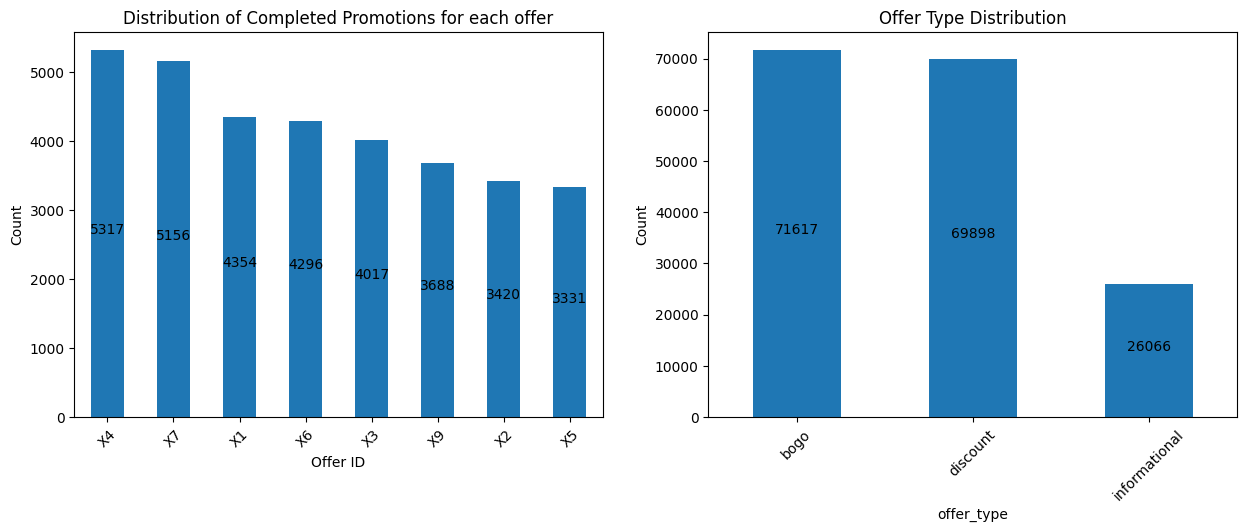

In [150]:
# Check the completed orders only

plt.subplot(121)
count_offer_id = df[df['event'] == 'offer completed']['offer_id'].value_counts()
count_offer_id.plot(kind='bar',figsize=(15, 5), rot=45)
plt.xlabel('Offer ID')
plt.ylabel('Count')
plt.title('Distribution of Completed Promotions for each offer')
addlabels(count_offer_id.index, count_offer_id.values);

plt.subplot(122)
count_offer_type = df['offer_type'].value_counts()
count_offer_type.plot(kind='bar',figsize=(15, 5), rot=45)
# plt.xlabel('Offer Type')
plt.ylabel('Count')
plt.title('Offer Type Distribution')
addlabels(count_offer_type.index, count_offer_type.values);



**4. Which values are the most frequently occurring in each dataframe's columns?**

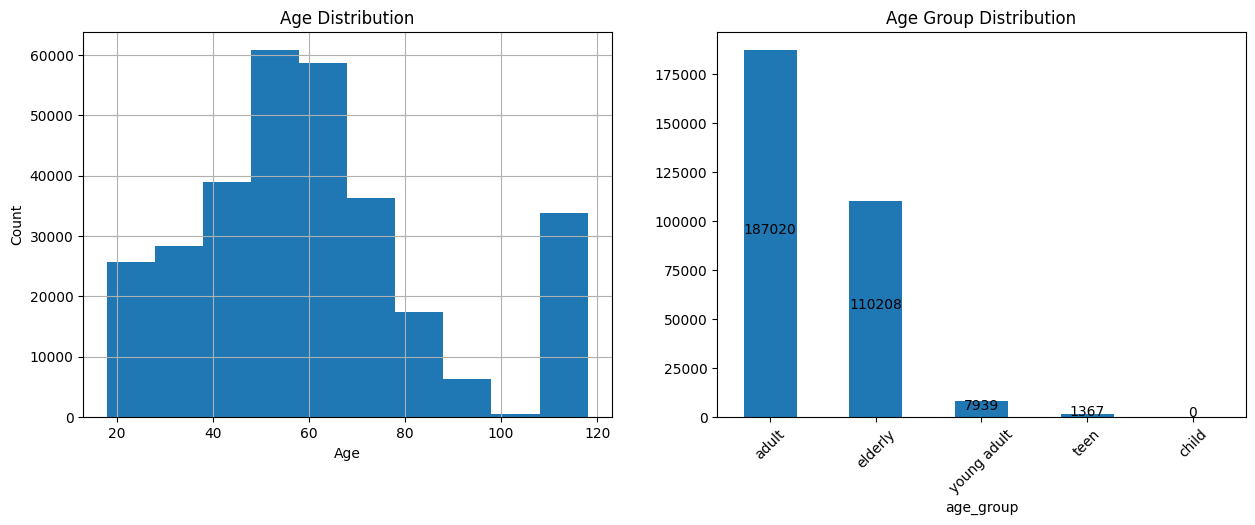

In [151]:
plt.subplot(121)
df['age'].hist()
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution');

plt.subplot(122)
count_age_group = df['age_group'].value_counts()
count_age_group.plot(kind='bar',figsize=(15, 5), rot=45)
# plt.xlabel('Age Group')
# plt.ylabel('Count')
plt.title('Age Group Distribution')
addlabels(count_age_group.index, count_age_group.values);



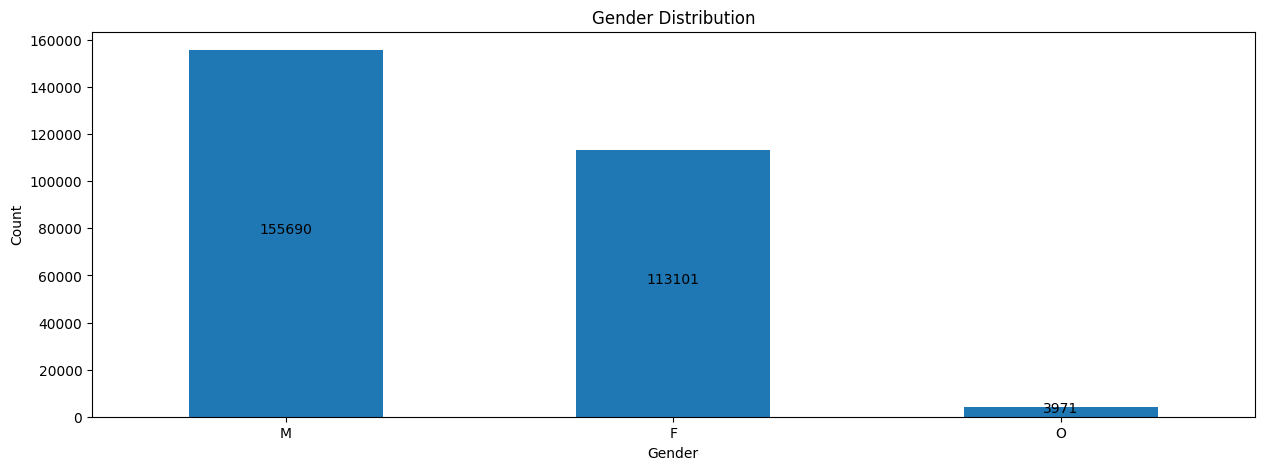

In [152]:
gender_count = df['gender'].value_counts()
gender_count.plot(kind='bar',figsize=(15, 5), rot=0)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
addlabels(gender_count.index, gender_count.values);

**5.Within the context of transcripts, who stands out as the most devoted customer?**


    Profile ID: A14827,
    Number of Completed Offers: 5,
    Amount: 1608.69
    

    Profile ID: A13476,
    Number of Completed Offers: 6,
    Amount: 1365.66
    

    Profile ID: A10782,
    Number of Completed Offers: 3,
    Amount: 1327.74
    

    Profile ID: A10653,
    Number of Completed Offers: 4,
    Amount: 1321.42
    

    Profile ID: A10310,
    Number of Completed Offers: 5,
    Amount: 1319.97
    


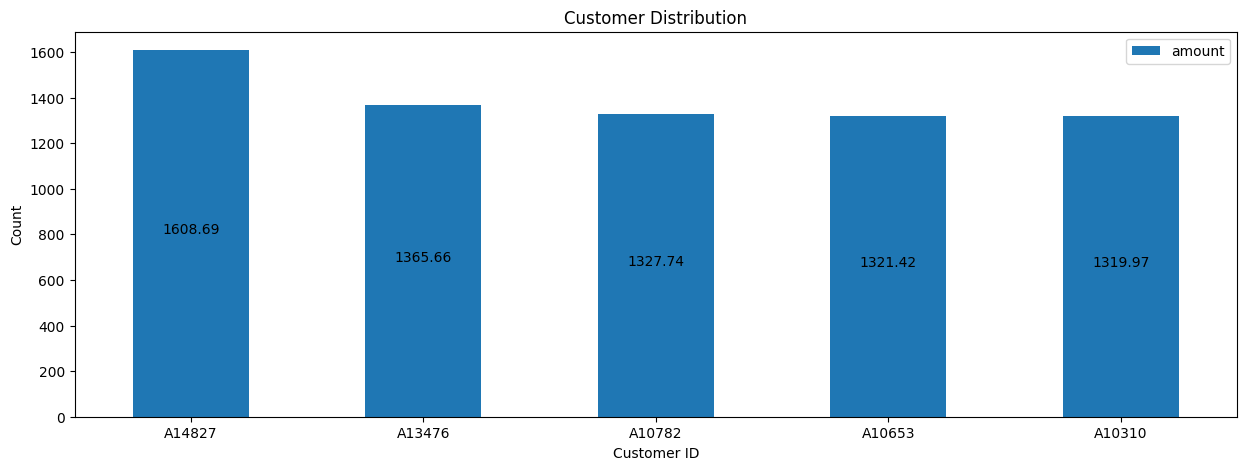

In [153]:
loyal_customer_count = df[(df['event'] == 'offer completed') | (df['event'] == 'transaction')].groupby(['customer_id', 'event'])['amount'].sum().reset_index()
loyal_customer_count = loyal_customer_count.sort_values('amount',ascending=False).head()

# Visualize
loyal_cus = loyal_customer_count.set_index('customer_id')
loyal_cus.plot(kind='bar',figsize=(15, 5), rot=0)
plt.xlabel('Customer ID')
plt.ylabel('Count')
plt.title('Customer Distribution')
addlabels(loyal_cus.index, loyal_cus['amount']);

for cus in loyal_customer_count['customer_id']:
    print('''
    Profile ID: {},
    Number of Completed Offers: {},
    Amount: {}
    '''.format(cus
               ,df[df['event'] == 'offer completed'].groupby('customer_id')['offer_id'].count().loc[cus]
               ,round(loyal_customer_count[loyal_customer_count['customer_id']==cus]['amount'].values[0], 2))
         )

    

## 2.2. Multvariate Exploration

# 1. Among children, teenagers, young adults, adults, and the elderly, which promotion garners the most popularity?
# 2. When examining profiles, who tends to have higher earnings, males or females?
# 3. What types of promotions are favored by each gender?

**1.  Among children, teenagers, young adults, adults, and the elderly, which promotion is the most favored?**

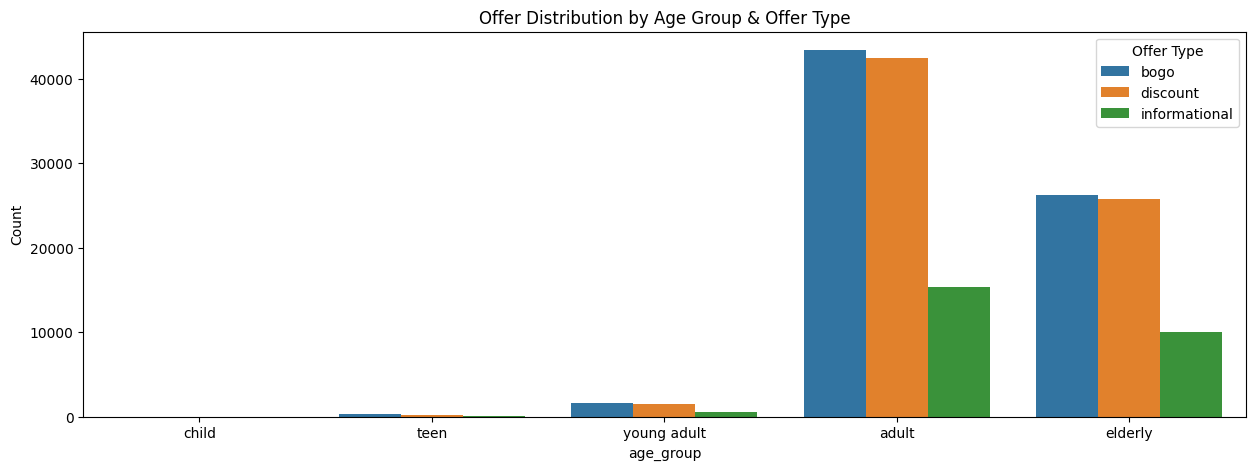

In [154]:
plt.figure(figsize=(15, 5))
sns.countplot(data=df, x='age_group', hue='offer_type')
plt.title('Offer Distribution by Age Group & Offer Type')
plt.ylabel('Count')
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

**2. Who, between males and females, tends to have higher earnings in profile data?**

Note: Exclude N/A because they didn't tell their gender

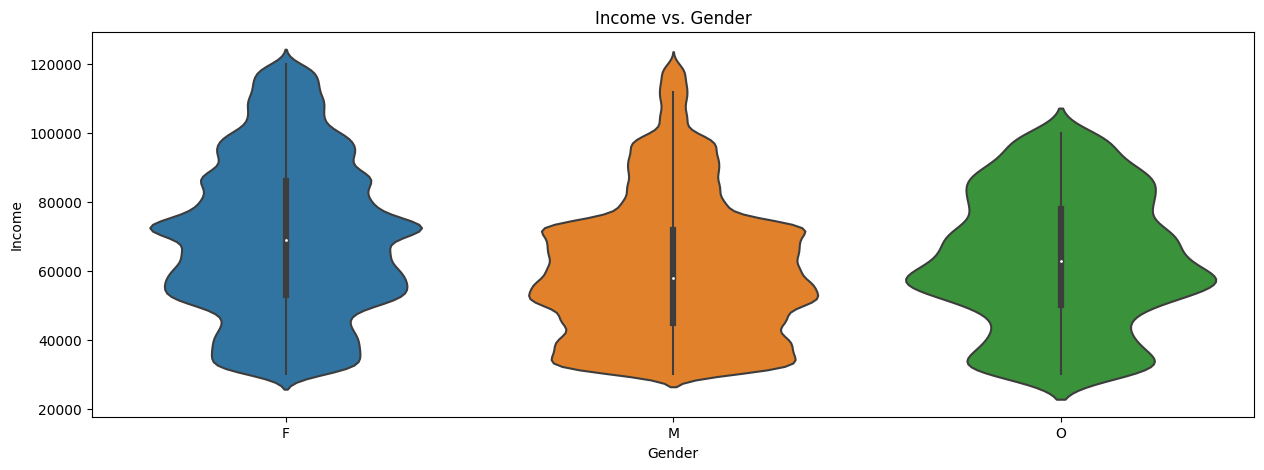

In [155]:
plt.figure(figsize=(15, 5))
sns.violinplot(x=df[df['gender'] != 'NA']['gender'], y=df['income'])
plt.title('Income vs. Gender')
plt.ylabel('Income')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

**Note:** The median is shown by the `white dot` in each graph.

**3. Which types of promotions are favored by each gender?**

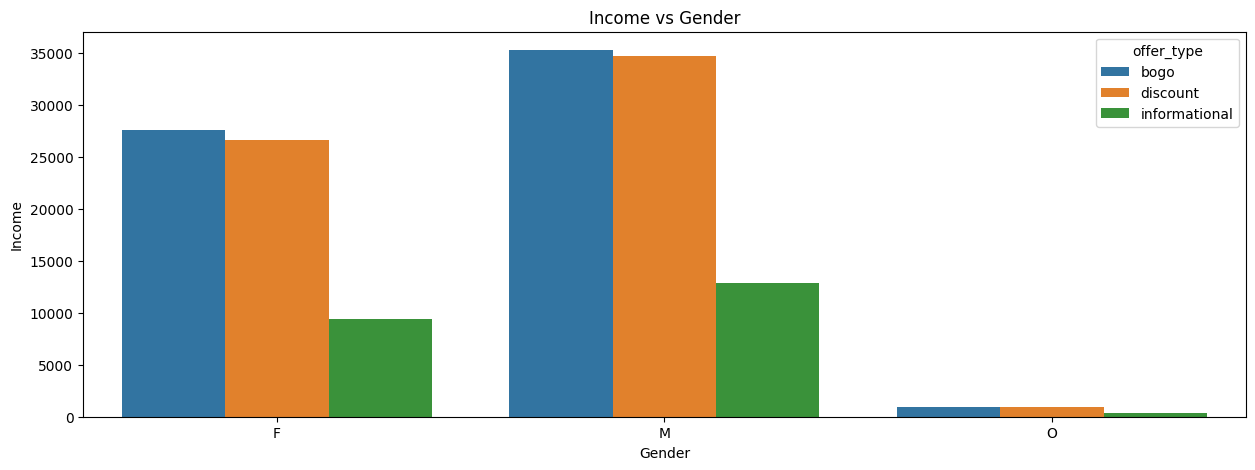

In [156]:
plt.figure(figsize=(15, 5))
sns.countplot(data=df, x=df[df['gender'] != 'NA']['gender'], hue = 'offer_type')
plt.title('Income vs Gender')
plt.ylabel('Income')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

# 3. Simple Linear Regression Machine Learning Model

This model aims to predict the **transaction amount** based on consumer age, income, and gender.

In [157]:
df.head()

,customer_id,event,time,offer_id,amount,gender,age,became_member_on,income,valid,reward,difficulty,duration,offer_type,email,mobile,social,web,age_group
0,A4,offer received,0,X1,NaN,F,75,2017-05-09,100000.000000,1,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,elderly
1,A5,offer received,0,X2,NaN,None,118,2017-08-04,65404.991568,0,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,elderly
2,A6,offer received,0,X3,NaN,M,68,2018-04-26,70000.000000,1,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,elderly
3,A7,offer received,0,X4,NaN,None,118,2017-09-25,65404.991568,0,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,elderly
4,A8,offer received,0,X5,NaN,None,118,2017-10-02,65404.991568,0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,elderly


In [158]:
# Extract data
df_ml = df[['amount','gender','age','income','event']]
df_ml = pd.concat([pd.get_dummies(df_ml['event']), df_ml.drop(columns=['event'])], axis=1)
df_ml = df_ml[['amount','gender','age','income','transaction']]

df_ml = df_ml[(df_ml['transaction'] == 1) & (df_ml['gender'] != 'O')]
df_ml = pd.concat([pd.get_dummies(df_ml['gender']), df_ml.drop(columns=['gender'])], axis=1)
df_ml.drop(columns=['transaction'], axis=1, inplace=True)

df_ml.head()

,F,M,amount,age,income
12654,True,False,0.83,20,30000.0
12657,False,True,34.56,42,96000.0
12659,False,True,13.23,36,56000.0
12670,True,False,19.51,55,94000.0
12671,True,False,18.97,39,67000.0


In [159]:
# Check NaN values
df_ml.isnull().mean()

F         0.0
M         0.0
amount    0.0
age       0.0
income    0.0
dtype: float64

In [160]:
# Define features and target as well as split train/test data
X = df_ml.drop('amount', axis=1)
y = df_ml['amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

scores = dict()

In [161]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Instantiate the StandardScaler
scaler = StandardScaler()

# Fit and transform your training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform your test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Instantiate, Fit & Predict
lr = LinearRegression() 
lr.fit(X_train_scaled, y_train) 
y_test_preds = lr.predict(X_test_scaled) 

scores['Scaling/Normalization'] = round(r2_score(y_test, y_test_preds), 2)

print(
'''
Scaling/Normalization: 
r-square score: {} on {} values.'''.format(round(r2_score(y_test, y_test_preds), 2), len(y_test))
)



Scaling/Normalization: 
r-square score: 0.07 on 41152 values.


In [162]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Fit scaler on the training data
norm = MinMaxScaler().fit(X_train)

# Transform
X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

# Instantiate, Fit & Predict
lr_norm = LinearRegression()  # Loại bỏ `normalize=True` ở đây
lr_norm.fit(X_train_norm, y_train)
y_test_preds = lr_norm.predict(X_test_norm)

scores['Normalization'] = round(r2_score(y_test, y_test_preds), 2)

print(
'''
Normalization: 
r-square score: {} on {} values.'''.format(round(r2_score(y_test, y_test_preds), 2), len(y_test))
)



Normalization: 
r-square score: 0.07 on 41152 values.


In [163]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

# List of numerical columns to be standardized
num_cols = ['age', 'income']  # Thay đổi các cột số học cần chuẩn hóa

# Standardize numerical features
for col in num_cols:
    scaler = StandardScaler()
    scaler.fit(X_train[[col]])
    X_train_stand[col] = scaler.transform(X_train_stand[[col]])
    X_test_stand[col] = scaler.transform(X_test_stand[[col]])

# Instantiate, Fit & Predict
lr_stand = LinearRegression()
lr_stand.fit(X_train_stand, y_train)
y_test_preds = lr_stand.predict(X_test_stand)

scores['Standardization'] = round(r2_score(y_test, y_test_preds), 2)

print(
'''
Standardization: 
r-square score: {} on {} values.'''.format(round(r2_score(y_test, y_test_preds), 2), len(y_test))
)



Standardization: 
r-square score: 0.07 on 41152 values.


In [164]:
score_df = pd.DataFrame()
score_df['model type'] = scores.keys()
score_df['r-square value'] = scores.values()
score_df

,model type,r-square value
0,Scaling/Normalization,0.07
1,Normalization,0.07
2,Standardization,0.07


## Conclusion

 The r-squared score remained consistent across all three approaches. Let's revisit the same r-squared score discussed earlier. In a linear regression model, features are not weighted based on their magnitudes as they would be in distance-based methods. Instead, each feature converges toward a minimum in a linear regression model, which operates as a form of gradient descent model. Without scaling, the descent rate and step size for each feature can vary, and this doesn't assign higher weights to larger magnitude features, but it can impact model performance because some features reach the minimum faster than others. Scaling numerical data in a linear regression model is generally advisable to enhance model stability and convergence time. However, as demonstrated in the preceding section, it may not be necessary in terms of feature weighting.

 The second item will delve into the r-squared value, which is expressed on a 0 to 100 percent scale, as explained in the metrics section. A higher percentage indicates a stronger correlation and greater accuracy in model predictions. Consequently, there appears to be a limited connection between the amount spent per transaction by consumers and their age, gender, or annual income in the model described above.



## Improvements

 I believe I've reached a point where I've achieved promising results and a reasonable understanding of the data. However, to enhance our outcomes, I intend to refine my data collection process and address any challenges related to NaN values. Additionally, I aim to acquire more information, including the location and timestamp of transactions, as well as details about the store branches and time of day. All of this additional information can play a crucial role in helping us determine when and where to target our offers more effectively.